In [2]:
import os
import shutil

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.environ['KAGGLE_CONFIG_DIR']="/content"

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:29<00:00, 42.0MB/s]
100% 2.29G/2.29G [00:29<00:00, 82.8MB/s]


In [5]:
shutil.copy2('/content/drive/My Drive/Untitled folder/Dataset.zip','.')

'./Dataset.zip'

In [6]:
from zipfile import ZipFile
fname='/content/Dataset.zip'
with ZipFile(fname,'r') as zip:
  zip.extractall()
  print('done')

fname='/content/chest-xray-pneumonia.zip'
with ZipFile(fname,'r') as zip:
  zip.extractall()
  print('done')


done
done


In [7]:
os.mkdir('dataset')
shutil.move('/content/covid','dataset')
shutil.move('/content/chest_xray/train/NORMAL','dataset')
shutil.move('/content/chest_xray/train/PNEUMONIA','dataset')

'dataset/PNEUMONIA'

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Lambda,Dense,Flatten,AveragePooling2D,Dropout
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,roc_curve
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [9]:
IMGE_SIZE=[224,224]

epochs=50
batch_size=32

covid_path='/content/dataset/covid'
normal_path='/content/dataset/NORMAL'
pneumonia_path='/content/dataset/PNEUMONIA'

covid_files=glob(covid_path+'/*')
normal_files=glob(normal_path+'/*')
pneumonia_files=glob(normal_path+'/*')

In [10]:
covid_labels=[]
normal_labels=[]
pneumonia_labels=[]

covid_images=[]
normal_images=[]
pneumonia_images=[]

import cv2
for i in range(len(covid_files)):
  image=cv2.imread(covid_files[i])
  image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  image=cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('covid')

for i in range(500):
  image=cv2.imread(normal_files[i])
  image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  image=cv2.resize(image,(224,224))
  normal_images.append(image)
  normal_labels.append('normal')

for i in range(500):
  image=cv2.imread(pneumonia_files[i])
  image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  image=cv2.resize(image,(224,224))
  pneumonia_images.append(image)
  pneumonia_labels.append('pneumonia')

In [11]:
#normalize to (0,1)
covid_images=np.array(covid_images)/255.0
normal_images=np.array(normal_images)/255.0
pneumonia_images=np.array(pneumonia_images)/255.0

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

#split to train,test
covid_x_train,covid_x_test,covid_y_train,covid_y_test=train_test_split(covid_images,covid_labels,test_size=.2)
normal_x_train,normal_x_test,normal_y_train,normal_y_test=train_test_split(normal_images,normal_labels,test_size=.2)
pneumonia_x_train,pneumonia_x_test,pneumonia_y_train,pneumonia_y_test=train_test_split(pneumonia_images,pneumonia_labels,test_size=.2)

X_train=np.concatenate((pneumonia_x_train,normal_x_train,covid_x_train),axis=0)
X_test=np.concatenate((pneumonia_x_test,normal_x_test,covid_x_test),axis=0)
Y_train=np.concatenate((pneumonia_y_train,normal_y_train,covid_y_train),axis=0)
Y_test=np.concatenate((pneumonia_y_test,normal_y_test,covid_y_test),axis=0)


# X_train=np.concatenate((normal_x_train,covid_x_train),axis=0)
# X_test=np.concatenate((normal_x_test,covid_x_test),axis=0)
# Y_train=np.concatenate((normal_y_train,covid_y_train),axis=0)
# Y_test=np.concatenate((normal_y_test,covid_y_test),axis=0)

In [13]:
# make labels imto categories 0 or 1
Y_train=LabelBinarizer().fit_transform(Y_train)
# Y_train=to_categorical(Y_train)

Y_test=LabelBinarizer().fit_transform(Y_test)
# Y_test=to_categorical(Y_test)

In [28]:
res=ResNet50(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

outputs=res.output
outputs=Flatten(name='flattern')(outputs)
outputs=Dropout(.5)(outputs)
outputs=Dense(64,activation='relu')(outputs)
outputs=Dropout(.5)(outputs)
outputs=Dense(3,activation='softmax')(outputs)

model=Model(inputs=res.input,outputs=outputs)

for layer in res.layers:
  layer.trainable=False

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

train_aug=ImageDataGenerator(
    rotation_range=20,
    width_shift_range=.2,
    height_shift_range=.2,
    horizontal_flip=True
)

In [ ]:
history=model.fit(train_aug.flow(X_train,Y_train,batch_size=32),
                  validation_data=(X_test,Y_test),
                  validation_steps=len(X_test)/32,
                  steps_per_epoch=len(X_train)/32,
                  epochs=50
)

Epoch 1/50
37/36 [==============================] - 14s 384ms/step - loss: 2.0894 - accuracy: 0.3201 - val_loss: 1.0986 - val_accuracy: 0.3448
Epoch 2/50
37/36 [==============================] - 13s 360ms/step - loss: 1.0985 - accuracy: 0.3460 - val_loss: 1.0984 - val_accuracy: 0.3448
Epoch 3/50
37/36 [==============================] - 13s 359ms/step - loss: 1.0983 - accuracy: 0.3460 - val_loss: 1.0982 - val_accuracy: 0.3448
Epoch 4/50
37/36 [==============================] - 13s 360ms/step - loss: 1.0980 - accuracy: 0.3460 - val_loss: 1.0980 - val_accuracy: 0.3448
Epoch 5/50
37/36 [==============================] - 13s 360ms/step - loss: 1.0979 - accuracy: 0.3460 - val_loss: 1.0979 - val_accuracy: 0.3448
Epoch 6/50
37/36 [==============================] - 13s 363ms/step - loss: 1.0978 - accuracy: 0.3460 - val_loss: 1.0978 - val_accuracy: 0.3448
Epoch 7/50
37/36 [==============================] - 13s 357ms/step - loss: 1.0976 - accuracy: 0.3460 - val_loss: 1.0977 - val_accuracy: 0.3448

In [16]:
y_pred=model.predict(X_test,batch_size=32)

In [17]:
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(Y_test, axis=1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Confusion Matrix without Normalization


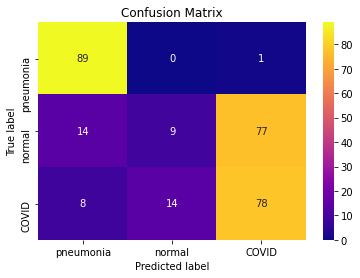

Confusion Matrix with Normalized Values


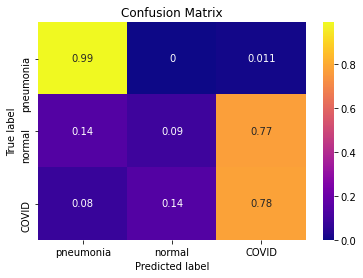

In [18]:
import seaborn as sns
def plot_confusion_matrix(normalize):
  classes = ['pneumonia','normal','COVID']
  tick_marks = [0.5,1.5,2.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [ ]:
Y_train

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [19]:
model.save("resnet_cxr.h5")

In [26]:
del model